# State-based dFC for continuously varying measures

The previous tutorials showed how to (1) estimate continuously varying dFC measures and (2) work with inherently state-based measures. However, Comet also allows users to perform clustering analysis on continuous measures.

We can simply use the same example as before to derive state measures for a single subject:

In [1]:
from matplotlib import pyplot as plt
from nilearn import datasets
from comet import connectivity, utils

# Preprocessed time series data from the ABIDE dataset
subject = 50010
data = datasets.fetch_abide_pcp(SUB_ID=subject, pipeline='cpac', band_pass_filtering=True, derivatives="rois_dosenbach160")
ts = data.rois_dosenbach160[0]

sw = connectivity.SlidingWindow(ts)
dfc_sw = sw.estimate()

[fetch_abide_pcp] Dataset found in /home/mibur/nilearn_data/ABIDE_pcp

Next, we can perform clustering analysis and extract some summary measures:

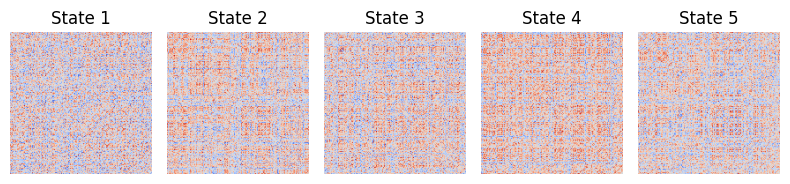

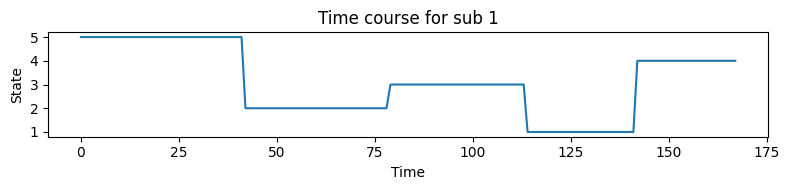

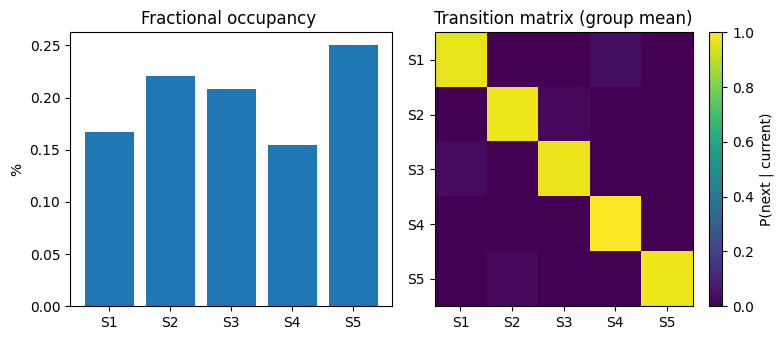

In [2]:
state_tc, states, inertia = utils.kmeans_cluster(dfc_sw, num_states=5, random_state=0)
summary = utils.summarise_state_tc(state_tc)

fig1, ax1 = utils.state_plots(states=states, figsize=(8,2))
fig2, ax2 = utils.state_plots(state_tc=state_tc, figsize=(8,2))
fig3, ax3 = utils.state_plots(summary=summary, figsize=(8,3.5))

More commonly, state-based analysis uses multiple subjects for estimating the state dynamics. For this, we can simply estimate dFC for multiple subjects and store the estimates in a list before performing the clustering analysis:

In [3]:
# Get data from 5 subjects
subjects = ["50008", "50010", "50012", "50014", "50020"]
data = datasets.fetch_abide_pcp(SUB_ID=subjects, pipeline='cpac', band_pass_filtering=True, derivatives="rois_dosenbach160")
ts = data.rois_dosenbach160 # list of 2D time series data

print("Number of subjects:",len(ts))
print("Time series shape:", ts[0].shape)

# Estimate dFC for all subjects and store as a list
dfc_list = []

for sub_ts in ts:
    dfc = connectivity.LeiDA(sub_ts).estimate()
    dfc_list.append(dfc)

[fetch_abide_pcp] Dataset found in /home/mibur/nilearn_data/ABIDE_pcp

Number of subjects: 5
Time series shape: (196, 161)


You can then estimate state dynamics. TO calculate popular summary metrics, the `summarise_state_tc` and `state_plots` functions are available:

Available summary metrics: dict_keys(['dwell_times', 'fractional_occupancy', 'transitions', 'transition_counts', 'transitions_sum', 'switch_rate'])

Average transition matrix:
[[0.75714584 0.04479001 0.0959456  0.01906433 0.08305423]
 [0.1161039  0.84320346 0.02623377 0.01160173 0.00285714]
 [0.0793259  0.03084854 0.84184852 0.04152543 0.00645161]
 [0.06036293 0.05572586 0.09631783 0.76354827 0.0240451 ]
 [0.07711042 0.         0.00588235 0.04150671 0.67550052]]


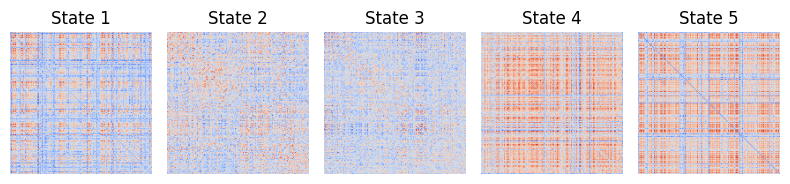

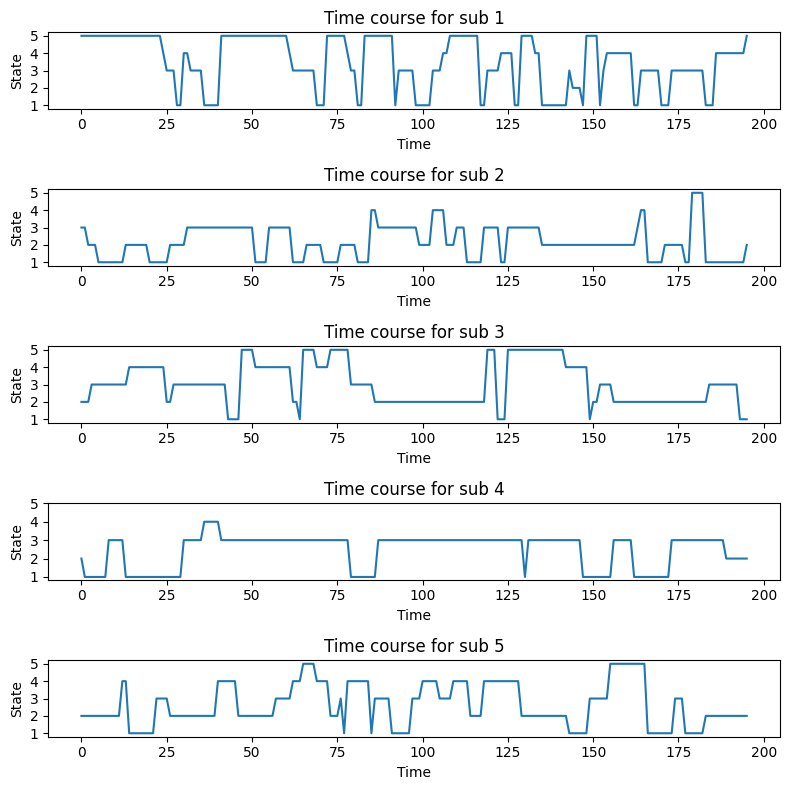

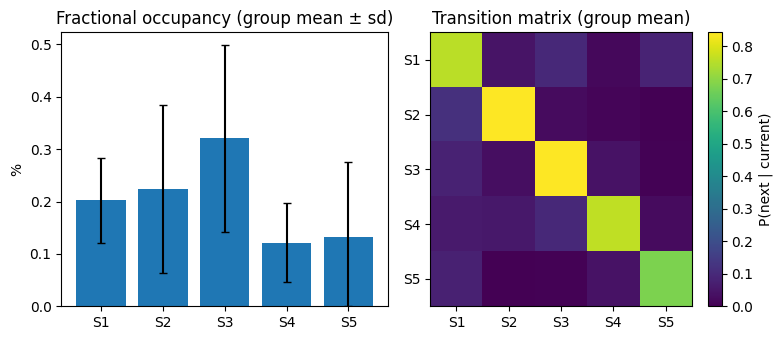

In [4]:
state_tc, states, inertia = utils.kmeans_cluster(dfc_list, strategy="pooled")
summary = utils.summarise_state_tc(state_tc)

print(f"Available summary metrics: {summary.keys()}\n")
print("Average transition matrix:")
print(summary["transitions"].mean(axis=0))

# Plot results
fig1, ax1 = utils.state_plots(states=states, figsize=(8,2))
fig2, ax2 = utils.state_plots(state_tc=state_tc, figsize=(8,8))
fig3, ax3 = utils.state_plots(summary=summary, figsize=(8,3.5))

The attentive reader might have noticed that there is the normal `SlidingWindow` class as well as the `SlidingWindowClustering` class for the state-based method. In practice, both classes yield equivalent results when `SlidingWindow` is combined with the two-level clustering strategy (strategy="two_level") implemented in `kmeans_cluster`:

In [5]:
# SlidingWindow + kmeans_cluster
dfc_list = []
for ts_i in ts:
    dfc_sw = connectivity.SlidingWindow(ts_i, windowsize=29, stepsize=1, shape="gaussian", diagonal=1).estimate()
    dfc_list.append(dfc_sw)
state_tc, _, _ = utils.kmeans_cluster(dfc_list, num_states=5, subject_clusters=5, strategy="two_level", random_state=42)

# SlidingWindowClustering
state_tc_swc, _ = connectivity.SlidingWindowClustering(ts, n_states=5, subject_clusters=5, windowsize=29, stepsize=1, random_state=42).estimate()

Sliding Window Clustering: 100%|██████████| 5/5 [00:21<00:00,  4.20s/it]


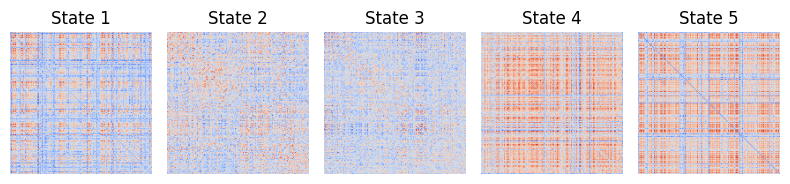

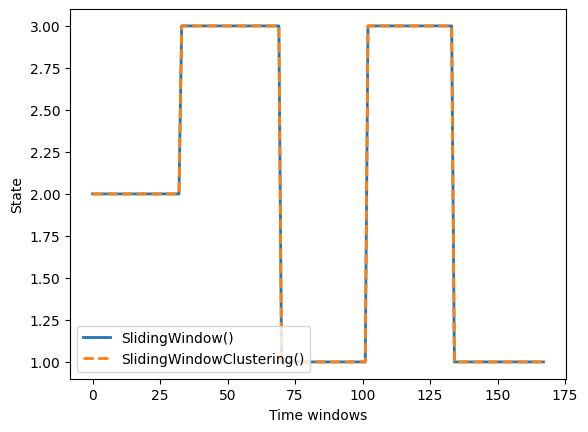

In [6]:
fig1, ax1 = utils.state_plots(states=states, figsize=(8,2))

sub_idx = 2

fig, ax = plt.subplots()
ax.plot(state_tc[sub_idx], label="SlidingWindow()", lw=2)
ax.plot(state_tc_swc[sub_idx], label="SlidingWindowClustering()", ls="--", lw=2)
ax.set(xlabel="Time windows", ylabel="State");
plt.legend(loc="lower left");